# Calculate the mean of a distribution from its histogram

Patricia Schuster  
2/21/18  

I am doing this because in the fission project, I want to calculate the average energy within an energy distribution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../scripts/')
import bicorr as bicorr

In [3]:
%load_ext autoreload
%autoreload 2

# Method for making a step plot

In [4]:
import inspect
print(inspect.getsource(bicorr.step_plot))

def step_plot(edges,y):
    """
    Plot a step plot. Meant for use with histogram data generated by:
        counts, bin_edges = np.histogram(x_samples,bin_edges)
        bicorr.step_plot(bin_edges,counts)
    
    Parameters
    ----------
    edges : ndarray
        Bin edges
    y : ndarray
        Bin counts

    Returns
    -------
    n/a
    """
    # Horizontal lines
    for i in range(len(y)):
        plt.hlines(y[i],edges[i],edges[i+1],linewidth=.5)
    # Vertical lines
    for i in range(len(y)-1):
        plt.vlines(edges[i+1],y[i],y[i+1],linewidth=.5)



# Generate some random data to work with

Using Normal-distributed data

In [5]:
x_samples = np.random.normal(0,5,150)

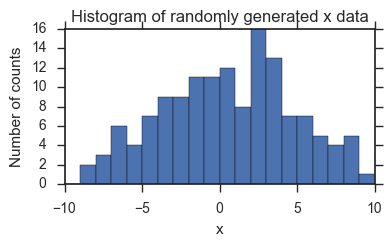

In [6]:
plt.figure(figsize=(4,2))
plt.hist(x_samples,np.arange(-10,10.1,1))
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.title('Histogram of randomly generated x data')
plt.show()

Store histogram data

In [7]:
counts, bin_edges = np.histogram(x_samples,np.arange(-10,10.1,1))

In [8]:
print(bin_edges.shape)
print(counts.shape)

(21,)
(20,)


In [9]:
bin_edges

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [10]:
counts

array([ 0,  2,  3,  6,  4,  7,  9,  9, 11, 11, 12,  8, 16, 13,  7,  7,  5,
        4,  5,  1], dtype=int64)

Look at it using my step plot function.

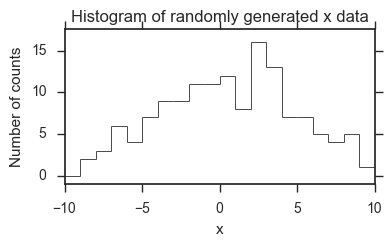

In [14]:
plt.figure(figsize=(4,2))
bicorr.step_plot(bin_edges,counts)
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Histogram of randomly generated x data')
plt.show()

# Calculate mean and associated error

Calculate the average x value for a distribution where we have $C$ counts for each $x$ value. Assume there is no error in $x_i$.

$x_{ave} = \frac{\Sigma(x_i \cdot C_i)}{\Sigma C_i}$

I am going to split this up into the numerator and the denomenator in order to propagate the error. 

$num = \Sigma(x_i \cdot C_i)$

$denom = \Sigma C_i$

## Numerator: $\Sigma(x_i\cdot C_i)$

Think of this as the sum of many products:

$num = x_1 c_1 + x_2 c_2 + ... = a + b + ...$

The error in each quantity is:

$\sigma_{x_i c_i} = x_i \sqrt{c_i}$

The error in the sum of these quantities is:

$\sigma_{num} = \sigma_{a+b+...} = \sqrt{\sigma_a^2+\sigma_b^2+...} = \sqrt{x_1^2 c_1 + x_2^2 c_2 + ...}$

## Denomenator: $\Sigma(C_i)$

This one is more straight forward. The error in the sum of many count quantities is the square root of the total number of counts.

$denom = c_1 + c_2 + ...$

$\sigma_{denom} = \sqrt{\sigma_{c_1}^2+\sigma_{c_2}^2...} = \sqrt{c_1 + c_2 + ...} = \sqrt{c_{sum}} = \sqrt{denom}$

## Put it together

$x_{ave} = \frac{num}{denom} = \frac{\Sigma(x_i \cdot C_i)}{\Sigma C_i}$

$\sigma_{x_{ave}} = x_{ave} \sqrt{(\frac{\sigma_{num}}{num})^2+(\frac{\sigma_{denom}}{denom})^2}$

## Functionalize it

In [34]:
def calc_mean(bin_edges, counts, print_flag = False):
    """
    Calculate mean of a count rate distribution, counts vs. x. 
    Errors are calculated under the assumption that you are working
        with counting statistics. (C_err = sqrt(C) in each bin)
    
    Parameters
    ----------
    bin_edges : ndarray
        Bin edges for x
    counts : ndarray
        Bin counts
    print_flag : bool
        Option to print intermediate values
    
    Returns
    -------
    x_mean : float
    x_mean_err : float
    """
    bin_centers = bicorr.centers(bin_edges)
    
    num = np.sum(np.multiply(bin_centers,counts))  
    num_err = np.sqrt(np.sum(np.multiply(bin_centers**2,counts)))
    denom = np.sum(counts)    
    denom_err = np.sqrt(denom)    

    if print_flag:
        print('num: ',num)
        print('num_err: ',num_err)
        print('denom: ',denom)
        print('denom_err: ',denom_err)
    
    x_mean = num/denom
    x_mean_err = x_mean * np.sqrt((num_err/num)**2+(denom_err/denom)**2)
    
    if print_flag:
        print('x_mean: ',x_mean)
        print('x_mean_err:',x_mean_err)
    
    return x_mean, x_mean_err

In [35]:
x_mean, x_mean_err = calc_mean(bin_edges,counts,True)

num:  80.0
num_err:  50.4479930225
denom:  140
denom_err:  11.8321595662
x_mean:  0.571428571429
x_mean_err: 0.36356471266


Plot this and look at the position of the mean.

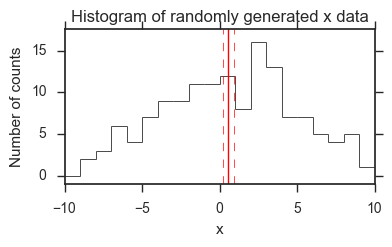

In [42]:
plt.figure(figsize=(4,2))
bicorr.step_plot(bin_edges,counts)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Histogram of randomly generated x data')
plt.show()

Look more closely to make sure it is evenly spaced.

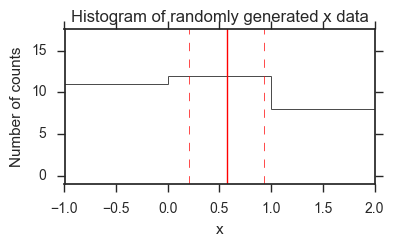

In [44]:
plt.figure(figsize=(4,2))
bicorr.step_plot(bin_edges,counts)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.xlabel('x')
plt.xlim([-1,2])
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Histogram of randomly generated x data')
plt.show()